# Inverse Autoregressive Flow (IAF)

### General normalizing flow set-up: 

The general idea is to transform an initial random variable from a simple distribution to a variable with a more complex distribution through a chain of invertible transformations $f_t$.

$$\mathbf{z}_0 \sim q(\mathbf{z}_0| \mathbf{x}), \mathbf{z}_t = f_t(\mathbf{z}_{t-1}, \mathbf{x})$$

We can compute the final pdf:
$$\log q(\mathbf{z}_T | \mathbf{x}) = \log q(\mathbf{z}_0|\mathbf{x}) - \sum_{t=1}^T \log \det|\frac{d\mathbf{z}_t}{d\mathbf{z}_{t-1}}|$$

### Motivation of IAF: 

Simple flows like planar/radial flow are useful only in low-dimensional space, we want to find a type of normalizing flow that scales well to high-dimensional space. 



### IAF model:

Let $[\boldsymbol{\mu}^t, \boldsymbol{\sigma}^t]$ be functions $R^d \rightarrow R^d$ satisfying autoregressive property (lower triangular).

Given target variable $\mathbf{y}$ and latent variable $\mathbf{z}_{t-1} = [z^{t-1}_0, ..., z^{t-1}_d]$ at iteration $(t-1)$ of the transformation. The flow $\mathbf{z}_{t} = f_t(\mathbf{z}_{t-1})$ is defined as:

* $z^t_0 = \mu^t_{0} + \sigma^t_{0}*z^{t-1}_0$

* For $i>0$, $z^t_i = \mu^t_{i}(\mathbf{z}^{t-1}_{0:i-1}) + \sigma^t_{i}(\mathbf{z}^{t-1}_{0:i-1})*z^{t-1}_i$

Note that each $[\mu^t_i, \sigma^t_i]$ only takes (the first $i-1$ elements of) the **previous** latent variable $\mathbf{z}_{t-1}$ as input . So this can be written in a compact form $\mathbf{z}_t = \boldsymbol{\mu}_t + \boldsymbol{\sigma}_t \circ \mathbf{z}_{t-1}$. And one advantage of this is that a single forward pass $\mathbf{y} = f_T\circ \dots \circ f_1(\mathbf{z})$ can be computed parallelly and efficiently, which benefits the sampling process.

However, the inverse operation for inference is expansive. Given data $\mathbf{y}$, the inverse of flow transformation $f_t$ can be derived as:

* $$z_0^{t-1} = \frac{z_0^t - \mu_0^t}{\sigma^t_0}$$

* $$z_i^{t-1} = \frac{z^t_i - \mu^t_{i}(\mathbf{z}^{t-1}_{0:i-1})}{\sigma^t_{i}(\mathbf{z}^{t-1}_{0:i-1})}$$

The inverse operation to compute $\mathbf{z}_{t-1}$ depends on its own (first $i - 1$) elements. As a consequence, the inverse computation $\mathbf{z} = f_T^{-1}\circ \dots \circ f_1^{-1}(\mathbf{y})$  must be done in a sequential order, which makes the inference (density estimation) process expensive. This motivates another methodology Masked Autoregressive Flow. 



# Masked Autoregressive Flow (MAF)

The MAF model is quite similar to the IAF model and they are an inverse version of each other. 

Given target variable $\mathbf{y}$ and latent variable $\mathbf{z}_{t-1} = [z^{t-1}_0, ..., z^{t-1}_d]$ at iteration $(t-1)$ of the transformation. The flow $\mathbf{z}_{t} = f_t(\mathbf{z}_{t-1})$ is defined as:

* $z^t_0 = \mu^t_{0} + \sigma^t_{0}*z^{t-1}_0$

* For $i>0$, $z^t_i = \mu^t_{i}(\mathbf{z}^t_{0:i-1}) + \sigma^t_{i}(\mathbf{z}^t_{0:i-1})*z^{t-1}_i$

Note that each $[\mu^t_{i}, \sigma^t_{i}]$ takes (the first $i-1$ elements of) the **new** latent variable $\mathbf{z}^t$ as input. This means the flow transformation must be done in a sequential order, which leads to an expensive forward pass and an inefficient sampling process. 

But we can see the advantage of MAF in density estimation. Consider the inverse transformation of $f_t$:

* $$z_0^{t-1} = \frac{z_0^t - \mu_0^t}{\sigma^t_0}$$

* $$z_i^{t-1} = \frac{z^t_i - \mu^t_{i}(\mathbf{z}^{t}_{0:i-1})}{\sigma^t_{i}(\mathbf{z}^{t}_{0:i-1})}$$

The computation of $\mathbf{z}_{t-1}$ only depends on $\mathbf{z}_t$, which distinguishes MAF from IAF. And this can be written in a compact form $\mathbf{z}_{t-1} = \frac{\mathbf{z}_t - \boldsymbol{\mu}_t}{\boldsymbol{\sigma}_t}$ and computed efficiently, which benefits the inference process (requiring inverse operation to evaluation the probability of a sample). 

**Question:** What distinguishes MAF methodology from MADE methodology?

Both IAF and MAF use MADE as their component layer. MAF is a normalizing flow that represents a invertable transformation applied to a distribution. MADE can be considered as a (network) layer, while MAF is a bijector with inverse operation. 

**Question**: Is the methodology coded up in the second block of [this documentation](https://www.tensorflow.org/probability/api_docs/python/tfp/bijectors/AutoregressiveNetwork) MADE or MAF? How to rationalize the comment "# Density estimation with MADE."?

> made = tfb.AutoregressiveNetwork(params=2, hidden_units=[10, 10])

This line constructs a layer function using MADE. 

> distribution = tfd.TransformedDistribution(
    distribution=tfd.Sample(tfd.Normal(loc=0., scale=1.), sample_shape=[2]),
    bijector=tfb.MaskedAutoregressiveFlow(made))

This part constructs a MAF model using MADE as its component layer (bijector function). The input of the model is a "base distribution", standard 2D normal in this case. 

**Question:** Why does IAF methodology exist when MAF methodology is already available?

As discussed above, IAF and MAF are actually an inverse version of each other. There exists trade-offs between MAF and IAF for efficient forward pass or efficient inverse operation. While MAF can do density estimation efficiently by computing the inverse operation parallelly, IAF can compute the forward pass $\mathbf{y} = f_T\circ \dots \circ f_1(\mathbf{z})$ efficiently. So if we need to sample a large amount of data from the model, IAF is preferred. 


**Question**: What is the primary methodological capability that distinguishes Normalizing Flows from GANs?

# TFP implementation using MAF

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_probability as tfp
tfb = tfp.bijectors
tfd = tfp.distributions
tfk = tf.keras
tfkl = tf.keras.layers

## 1) 2D example

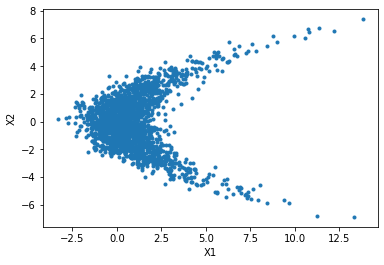

In [6]:
# Generate data X1 = X2^2 / 4

n = 2000
x2 = np.random.randn(n).astype(dtype=np.float32) * 2.
x1 = np.random.randn(n).astype(dtype=np.float32) + (x2 * x2 / 4.)
data = np.stack([x1, x2], axis=-1)
plt.plot(x1, x2, ".")
plt.xlabel("X1")
plt.ylabel("X2")
plt.show()

### estimate density using MAF 

In [96]:
# A layer function of MADE (bijector function for MAF)
made1 = tfb.AutoregressiveNetwork(params=2, hidden_units=[50,50])
# made2 = tfb.AutoregressiveNetwork(params=2, hidden_units=[50,50])
# made3 = tfb.AutoregressiveNetwork(params=2, hidden_units=[50,50])

# Target distrbution transformed by MAF (3 layers)
distribution = tfd.TransformedDistribution(
    distribution=tfd.MultivariateNormalDiag(loc=[0,0], scale_diag=[1,1]), # base: 2D Gaussian
    bijector=tfb.MaskedAutoregressiveFlow(made1))
# distribution = tfd.TransformedDistribution(distribution, bijector=tfb.MaskedAutoregressiveFlow(made2))
# distribution = tfd.TransformedDistribution(distribution, bijector=tfb.MaskedAutoregressiveFlow(made3))

# fit tf model
inputs = tfkl.Input(shape=(2,))
outputs = distribution.log_prob(inputs)
model = tfk.Model(inputs, outputs)

def neg_log(true, output):
  return -output
model.compile(optimizer=tf.optimizers.Adam(), loss=neg_log)
model.fit(x=data, y=np.zeros(n), epochs=10, verbose=False) # y does not matter (unsupervised)

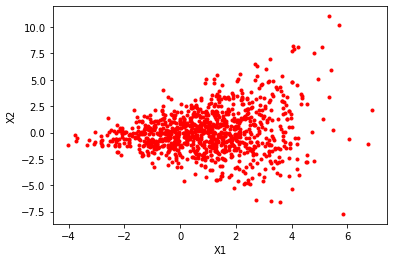

In [97]:
# Sampling from the estimated density for visualization

samples = distribution.sample(1000)
x1_hat = samples[:, 0]
x2_hat = samples[:, 1]
plt.plot(x1_hat, x2_hat, "r.")
plt.xlabel("X1")
plt.ylabel("X2")
plt.show()

I don't know the bottleneck here. I have tried increasing the hidden size and the number of flows, but the estimated density does not seem to fit well. Is that the limitation of the base distribution?

### estimate density using IAF

In [98]:
# MADE layer
made = tfb.AutoregressiveNetwork(params=2, hidden_units=[512,512])
# IAF model 
iaf = istribution = tfd.TransformedDistribution(
    distribution=tfd.MultivariateNormalDiag(loc=[0,0], scale_diag=[1,1]), # base: 2D Gaussian
    bijector=tfb.Invert(tfb.MaskedAutoregressiveFlow(made)))  # just need to invert the maf
# fit model
inputs = tfkl.Input(shape=(2,))
outputs = distribution.log_prob(inputs)
model = tfk.Model(inputs, outputs)

model.compile(optimizer=tf.optimizers.Adam(), loss=neg_log)
model.fit(x=data, y=np.zeros(n), epochs=10, verbose=False)

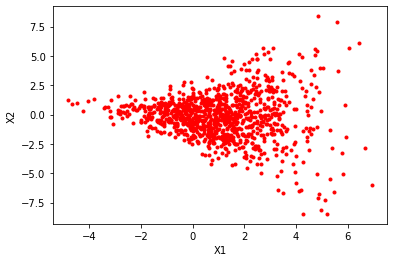

In [107]:
# Sampling from the estimated density for visualization

samples = distribution.sample(1000)
x1_hat = samples[:, 0]
x2_hat = samples[:, 1]
plt.plot(x1_hat, x2_hat, "r.")
plt.xlabel("X1")
plt.ylabel("X2")
plt.show()

The result is similar to the MAF approach.

## 2) Conditional density estimation example

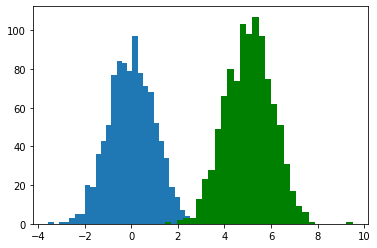

In [55]:
# Generate condition c and data x

n = 2000
c = np.r_[np.zeros(n//2), np.ones(n//2)]
x = np.r_[np.random.randn(n//2), np.random.randn(n//2) + 5]

plt.hist(x[:n//2],bins=30)
plt.hist(x[n//2:],bins=30,color='g')
plt.show()

In [80]:
# MADE layer
made_cond = tfb.AutoregressiveNetwork(params=2, hidden_units=[50, 50], event_shape=(1,),
                                 conditional=True, conditional_event_shape=(1,))
# MAF model
distribution = tfd.TransformedDistribution(
    distribution=tfd.Sample(tfd.Normal(loc=0., scale=1.), sample_shape=[1]), # Why we need a Sample function here?
    bijector=tfb.MaskedAutoregressiveFlow(made_cond))
# fit model
inputs_x = tfkl.Input(shape=(1,))
inputs_c = tfkl.Input(shape=(1,))
outputs = distribution.log_prob(inputs_x, bijector_kwargs={'conditional_input': inputs_c})
model = tfk.Model([inputs_x, inputs_c], outputs)

model.compile(optimizer=tf.optimizers.Adam(), loss=neg_log)
model.fit(x=[x, c], y=np.zeros(n), epochs=10, verbose=False) 

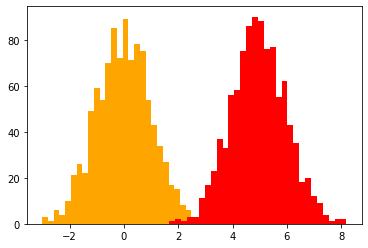

In [89]:
# Sampling from the estimated density for visualization

samples_0 = distribution.sample(1000, bijector_kwargs={"conditional_input": np.zeros((1000,1))})
samples_1 = distribution.sample(1000, bijector_kwargs={"conditional_input": np.ones((1000,1))})

plt.hist(tf.squeeze(samples_0), bins=30, color='orange')
plt.hist(tf.squeeze(samples_1), bins=30, color='r')
plt.show()

1D estimated density fits well.


# References

* https://arxiv.org/abs/1606.04934

* https://arxiv.org/abs/1705.07057

* http://akosiorek.github.io/ml/2018/04/03/norm_flows.html

* https://www.ritchievink.com/blog/2019/11/12/another-normalizing-flow-inverse-autoregressive-flows/

* https://arxiv.org/abs/2006.10175